In [51]:
import mysql.connector
import pandas as pd
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

In [2]:
with open('user.txt', 'r') as file:
    user, pwd = file.read().split('\n')

mydb = mysql.connector.connect(host="localhost", user=user, password=pwd, database='DMARC')
mycursor = mydb.cursor()
database = pd.read_sql('SELECT * FROM RUA', mydb)

C:\Users\User\AppData\Local\Temp\ipykernel_6884\3605022304.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  database = pd.read_sql('SELECT * FROM RUA', mydb)


In [4]:
spf = database['spf_aligned'].value_counts().rename_axis('labels').reset_index(name='count')
if len(spf) == 2:
    spf_aligned = [spf['count'][0], spf['count'][1]]
elif len(spf) == 1 and spf['labels'][0] == '0':
    spf_aligned = [spf['count'][0], 0]
elif len(spf) == 1 and spf['labels'][0] == '1':
    spf_aligned = [0, spf['count'][0]]

dkim = database['dkim_aligned'].value_counts().rename_axis('labels').reset_index(name='count')
if len(dkim) == 2:
    dkim_aligned = [dkim['count'][0], dkim['count'][1]]
elif len(dkim) == 1 and dkim['labels'][0] == '0':
    dkim_aligned = [dkim['count'][0], 0]
elif len(dkim) == 1 and dkim['labels'][0] == '1':
    dkim_aligned = [0, dkim['count'][0]]

dmarc = database['dmarc_aligned'].value_counts().rename_axis('labels').reset_index(name='count')
if len(dmarc) == 2:
    dmarc_aligned = [dmarc['count'][0], dmarc['count'][1]]
elif len(dmarc) == 1 and dmarc['labels'][0] == '0':
    dmarc_aligned = [dmarc['count'][0], 0]
elif len(dmarc) == 1 and dmarc['labels'][0] == '1':
    dmarc_aligned = [0, dmarc['count'][0]]

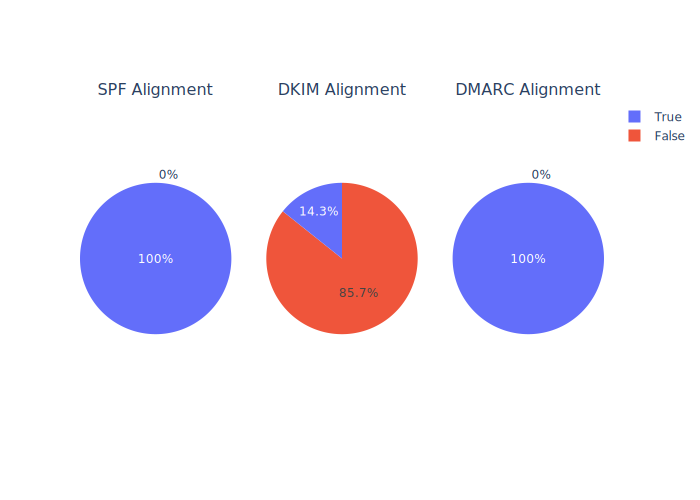

In [9]:
fig = make_subplots(rows=1, cols=3, specs=[[{"type": "pie"}, {"type": "pie"}, {"type": "pie"}]], 
                    subplot_titles=('SPF Alignment', 'DKIM Alignment', 'DMARC Alignment'))

fig.add_trace(go.Pie(values=spf_aligned, labels=['False','True'], domain=dict(x=[0, 0.5])), row=1, col=1)
fig.add_trace(go.Pie(values=dkim_aligned, labels=['False','True'], domain=dict(x=[0, 0.5])), row=1, col=2)
fig.add_trace(go.Pie(values=dmarc_aligned, labels=['False','True'], domain=dict(x=[0, 0.5])), row=1, col=3)
fig.show(renderer='svg')

In [42]:
fig = px.pie(database, names='spf_aligned', color='spf_aligned', color_discrete_map={'0':'#F9A603', '1':'#32CD32'}, title='SPF Alignment')
fig.update_layout(autosize=False, width=400, height=400)
fig.show()

In [43]:
fig = px.pie(database, names='dkim_aligned', color='dkim_aligned', color_discrete_map={'0':'#F9A603', '1':'#32CD32'}, title='DKIM Alignment')
fig.update_layout(autosize=False, width=400, height=400)
fig.show()

In [44]:
fig = px.pie(database, names='dmarc_aligned', color='dmarc_aligned', color_discrete_map={'0':'#F9A603', '1':'#32CD32'}, title='DMARC Alignment')
fig.update_layout(autosize=False, width=400, height=400)
fig.show()

In [62]:
database['day'] = database['begin_date'].str.slice(0, 10)

In [84]:
db_day = database.groupby(by=database['day']).sum()
db_day['spf_pass'] = db_day['spf_result'].str.count('pass')
db_day['spf_fail'] = db_day['spf_result'].str.count('fail')
db_day['dkim_pass'] = db_day['dkim_result'].str.count('pass')
db_day['dkim_fail'] = db_day['dkim_result'].str.count('fail')

db_day.reset_index(inplace=True)

In [83]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=db_day['day'], y=db_day['spf_fail'], mode='lines', name='fail'))
fig.add_trace(go.Scatter(x=db_day['day'], y=db_day['spf_pass'], mode='lines', name='pass'))
fig.update_layout(title='SPF Results Over Time')
fig.show()

In [86]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=db_day['day'], y=db_day['dkim_fail'], mode='lines', name='fail'))
fig.add_trace(go.Scatter(x=db_day['day'], y=db_day['dkim_pass'], mode='lines', name='pass'))
fig.update_layout(title='DKIM Results Over Time')
fig.show()